<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/NADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

fatal: destination path 'nn_hallucinations' already exists and is not an empty directory.


In [0]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions 
from torch import nn
from torch import optim
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets

In [0]:
def flatten(x):
  return x.view(-1)
  

def binarize(x):
  # TODO(eugenhotaj): Since binarize is called once per epoch, examples will
  # be sampled slightly different each epoch.
  return distributions.Bernoulli(probs=x).sample()

In [0]:
BATCH_SIZE = 512
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    flatten,
    binarize])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

In [0]:
class NADE(nn.Module):
  """Implementation of the Neural Autoregressive Distribution Estimator (NADE).

  NADE can be viewed as a one hidden layer autoencoder trained with a "language
  model criterion", i.e. trained to approximate p(x_i | x_{j<i}). The 
  connectivity pattern of NADE is specialized to enable this training criterion.
  
  For full details, see the paper by Larochelle & Murray (2011).
  """

  def __init__(self, input_dim, hidden_dim):
    """Initializes a new NADE instance.

    Args:
      input_dim: The dimension of the input.
      hidden_dim: The dimmension of the hidden layer. NADE only supports one
        hidden layer.
    """
    super().__init__()
    self._input_dim = input_dim
    self._hidden_dim = hidden_dim
    self.params = nn.ParameterDict({
      'in_W': nn.Parameter(torch.zeros(self._hidden_dim, self._input_dim)),
      'in_b': nn.Parameter(torch.zeros(self._hidden_dim,)),
      'h_W': nn.Parameter(torch.zeros(self._input_dim, self._hidden_dim)),
      'h_b': nn.Parameter(torch.zeros(self._input_dim,)),
    })
    nn.init.kaiming_normal_(self.params['in_W'])
    nn.init.kaiming_normal_(self.params['h_W'])

  def _forward(self, x):
    """Computes a forward pass and samples a new output.
    
    Returns:
      (p_hat, x_hat) where p_hat is the probability distribution over dimensions
      and x_hat *might* be sampled from p_hat. See the 'sample' method for
      specifics of sampling.
    """
    in_W, in_b = self.params['in_W'], self.params['in_b']
    h_W, h_b = self.params['h_W'], self.params['h_b']
    batch_size = 1 if x is None else x.shape[0] 

    p_hat = []
    x_hat = []
    # Only the bias is used to compute the first hidden unit so we must 
    # replicate it to account for the batch size.
    a = in_b.expand(batch_size, -1)
    for i in range(self._input_dim):
      h = torch.relu(a)
      p_i = torch.sigmoid(h_b[i:i+1] + h @ h_W[i:i+1, :].t())
      p_hat.append(p_i)

      # Sample 'x' at dimension 'i' if it is not given.
      x_i = x[:, i:i+1]
      x_i = torch.where(x_i < 0, 
                        distributions.Bernoulli(probs=p_i).sample(),
                        x_i)
      x_hat.append(x_i)

      # We do not need to add in_b[i:i+1] when computing the other hidden units
      # since it was already added when computing the first hidden unit. 
      a = a + x_i @ in_W[:, i:i+1].t()
    return torch.cat(p_hat, dim=1), torch.cat(x_hat, dim=1) if x_hat else []

  def forward(self, x):
    """Computes a forward pass."""
    # return self._forward(x)[0]
    return self._forward(x)[0]

  def sample(self, conditioned_on=None):
    """Samples a new image.
    
    Args:
      conditioned_on: An (optional) image to condition samples on. Only 
        dimensions with values < 0 will be sampled. For example, if 
        conditioned_on[i] = -1, then output[i] will be sampled conditioned on
        dimensions j < i. If 'None', an unconditional sample will be generated.
    """
    with torch.no_grad():
      if conditioned_on is None:
        device = next(self.parameters()).device
        conditioned_on = (torch.ones((1, self._input_dim)) * -1).to(device)
      return self._forward(conditioned_on)[1]

In [0]:
def train(model, 
          optimizer, 
          loss_fn, 
          train_loader, 
          eval_loader,
          n_epochs,
          device=torch.device('cpu')):
  model = model.to(device)

  train_losses = []
  eval_losses = []
  for epoch in range(n_epochs):
    model.train()

    train_loss = 0.
    n_examples = 0
    for x, _ in train_loader:
      x = x.to(device)
      n_examples += x.shape[0]
      
      optimizer.zero_grad()
      x_hat = model(x)
      loss = loss_fn(x_hat, x)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * x.shape[0]
    train_loss = train_loss / n_examples
    eval_loss = eval(model, optimizer, loss_fn, eval_loader, device)
    print(f'[{epoch + 1}] train_loss={train_loss} eval_loss={eval_loss}')
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

  return train_losses, eval_losses 

def eval(model, optimizer, loss_fn, eval_loader, device=torch.device('cpu')):
  model = model.to(device)
  model.eval()

  eval_loss = 0.
  n_examples = 0
  with torch.no_grad():
    for x, _ in eval_loader:
      x = x.to(device)
      n_examples += x.shape[0]

      x_hat = model(x)
      loss = loss_fn(x_hat, x)
      eval_loss += loss.item() * x.shape[0]
  return eval_loss / n_examples 

In [122]:
INPUT_SIZE = 784
HIDDEN_SIZE = 784
N_EPOCHS = 50

model = NADE(INPUT_SIZE, HIDDEN_SIZE).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')
loss_fn = lambda y_hat, y: bce_loss_fn(y_hat, y).sum(dim=1).mean()

train_losses, eval_losses = train(model, 
                                  optimizer, 
                                  loss_fn, 
                                  train_loader, 
                                  test_loader, 
                                  N_EPOCHS, 
                                  colab_utils.get_device())

[1] train_loss=195.2101052734375 eval_loss=113.79951000976563
[2] train_loss=106.5165678141276 eval_loss=100.13169954833984
[3] train_loss=98.7624634765625 eval_loss=95.97132420654297
[4] train_loss=95.66003694661458 eval_loss=93.85800509033203
[5] train_loss=93.88181385498046 eval_loss=92.59775539550782
[6] train_loss=92.67671538085938 eval_loss=91.64253970947266
[7] train_loss=91.78545729166666 eval_loss=90.84754544677735
[8] train_loss=91.02877840983074 eval_loss=90.17508248291016
[9] train_loss=90.36942124430338 eval_loss=89.72037819824219
[10] train_loss=89.8851544148763 eval_loss=89.31890919189453
[11] train_loss=89.42845310872396 eval_loss=88.93714747314453
[12] train_loss=89.02986235351563 eval_loss=88.48451390380859
[13] train_loss=88.648012109375 eval_loss=88.36587416992188
[14] train_loss=88.30377129720053 eval_loss=88.01166525878907
[15] train_loss=88.07166848958333 eval_loss=87.77003194580078
[16] train_loss=87.77766849365234 eval_loss=87.52743040771485
[17] train_loss=87.

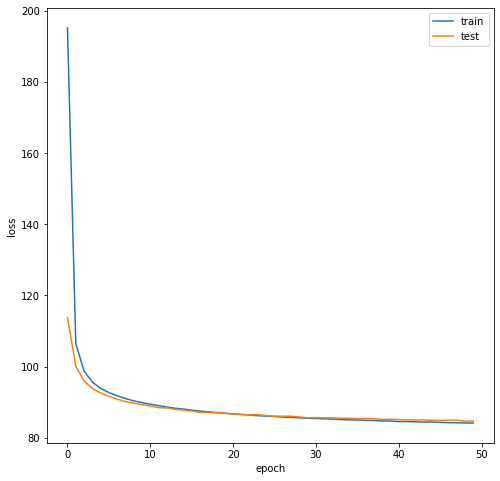

In [123]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))

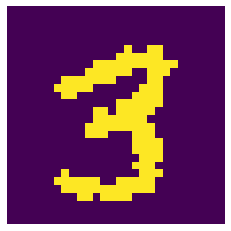

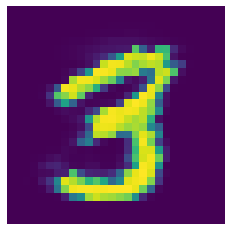

In [125]:
show_random(model, test_loader.dataset)

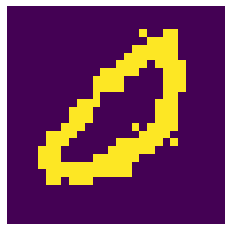

In [140]:
colab_utils.imshow(model.sample().reshape(28, 28))

In [0]:
def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

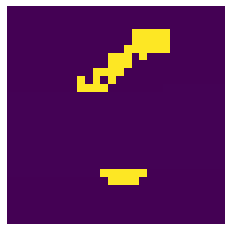

Conditional Samples:


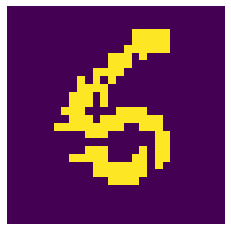

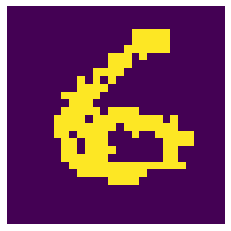

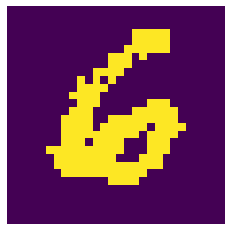

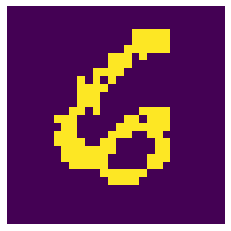

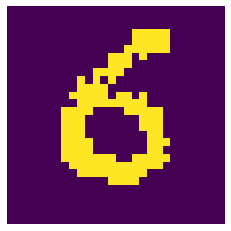

In [142]:
conditional_sample_random(model, test_loader.dataset)